In [1]:
import os
import subprocess
import pandas as pd

imn="a.jpg"

#tp['FaceRecords'][0]['Face']['BoundingBox']

os.system("aws s3 cp "+imn+" s3://litmind/a.jpg")
proc = subprocess.Popen(['aws rekognition index-faces --image "S3Object={Bucket=litmind,Name=a.jpg}" --region us-east-1 --collection-id "examplecollection" --detection-attributes "ALL"'], stdout=subprocess.PIPE, shell=True)
(out, err) = proc.communicate()


proc1 = subprocess.Popen(['aws rekognition detect-labels --image "S3Object={Bucket=litmind,Name=a.jpg}" --region us-east-1'], stdout=subprocess.PIPE, shell=True)
(out1, err) = proc1.communicate()
#print "program output:", out

import simplejson as json

tp=json.loads(out)
labels=json.loads(out1)


os.system("aws s3 rm s3://litmind/a.jpg")

my_json = out.decode('utf8').replace("'", '"')
#print(my_json)
#print(out)
#print('- '*20)
#s = json.dumps(my_json, indent=4, sort_keys=True)
#print(s)
noOfPeople=0  #no of faces in the pic
age=[]
emo2d=[]
emoConfidence2d=[]
gender=[]
human=[]
kid=[]
happy=[]
sad=[]
angry=[]


faceNo=0
gen=""
emo=[]
emoConfidence=[]
flagHappy=0
flagSad=0
flagAngry=0
for i in tp['FaceRecords']:
	l_age = tp['FaceRecords'][faceNo]['FaceDetail']['AgeRange']['Low']
	h_age = tp['FaceRecords'][faceNo]['FaceDetail']['AgeRange']['High']
	age.append((l_age+h_age)/2)
	gen=(tp['FaceRecords'][faceNo]['FaceDetail']['Gender']['Value'])
	if(gen=="Female"):		#Gender- 1 for male, 0 for female
		gender.append(0)
	elif (gen=="Male"):
		gender.append(1)
	emoNo=0
	for j in tp['FaceRecords'][faceNo]['FaceDetail']['Emotions']:
		emo=(tp['FaceRecords'][faceNo]['FaceDetail']['Emotions'][emoNo]['Type'])
		if emo=="HAPPY":
			flagHappy=1
		if emo=="SAD":
			flagSad=1
		if emo=="ANGRY":
			flagAngry=1
		#emoConfidence.append(tp['FaceRecords'][faceNo]['FaceDetail']['Emotions'][emoNo]['Confidence'])
		emoNo+=1
	if(flagHappy==1):
		happy.append(1)
	else:
		happy.append(0)
	if(flagSad==1):
		sad.append(1)
	else:
		sad.append(0)
	if(flagAngry==1):
		angry.append(1)
	else:
		angry.append(0)
	#emo2d.append(emo)
	#emoConfidence2d.append(emoConfidence)
	#emo=[]
	#emoConfidence=[]
	faceNo+=1
noOfPeople=faceNo
print noOfPeople
print(age)
print(happy)
print(sad)
print(angry)
print(gender)

def getLabels(labels):
	labelNo=0
	flagHuman=0
	flagChild=0
	for i in labels["Labels"]:
		name=labels["Labels"][labelNo]["Name"]
		if((name=="Person") or (name=="People") or (name=="Human")):
			flagHuman=1
		labelNo+=1
	if(flagHuman==1):				#Human- 1 for human, 0 for non-human
		human.append(1)
	else:
		human.append(0)

faceData=pd.DataFrame()
faceData["Age"]="NaN"
faceData["Happy"]="NaN"
faceData["Sad"]="NaN"
faceData["Angry"]="NaN"
faceData["Gender"]="NaN"

data=[]
data2d=[]


print(data2d)
#getFaceFeatures(tp)
#print(labels)
getLabels(labels)

print noOfPeople

for i in range(noOfPeople):
	data.append(age[i])
	data.append(happy[i])
	data.append(sad[i])
	data.append(angry[i])
	data.append(gender[i])
	data2d.append(data)
	data=[]

##cropper
print noOfPeople

from PIL import Image
im=Image.open(imn)
width, height = im.size

print height
print width


3
[54, 43, 35]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 0, 0]
[]
3
3
183
276


In [2]:

for k in range(noOfPeople):
    print "face no : "+str(k);
    p=tp['FaceRecords'][k]['Face']['BoundingBox']
    for i in tp['FaceRecords'][k]['FaceDetail']['Landmarks']:

        if i['Type']=='eyeLeft':
            x1=i['X']*width
            y1=i['Y']*height
        elif i['Type']=='mouthRight':
            x2=i['X']*width
            y2=i['Y']*height
    x1=x1-p['Width']*width/2.5
    x1=x1 if x1>0 else 0;
    y1=y1-p['Height']*height/2
    y1=y1 if y1>0 else 0;
    x2=x2+p['Width']*width/3
    x2=x2 if x2<width else width;
    y2=y2+p['Height']*height/3
    y2=y2 if y2<height else height;
    ni="f"+str(k)+".jpg"
    im.crop((x1, y1,x2, y2)).resize((200, 200), Image.ANTIALIAS).save(ni)


face no : 0
face no : 1
face no : 2


In [3]:
data2d

[[54, 1, 1, 1, 1], [43, 1, 1, 1, 0], [35, 1, 1, 1, 0]]

In [4]:
## CREATE A COLLECTION

proc = subprocess.Popen(['aws rekognition create-collection --collection-id "f"'], stdout=subprocess.PIPE, shell=True)
(out, err) = proc.communicate()

## populating a face

os.system("aws s3 cp f1.jpg s3://litmind/f1.jpg")

proc = subprocess.Popen(['aws rekognition index-faces --image "S3Object={Bucket=litmind,Name=f1.jpg}" --region us-east-1 --collection-id "f" --detection-attributes "ALL" --external-image-id "GOPAL"'], stdout=subprocess.PIPE, shell=True)
(out, err) = proc.communicate()

In [5]:
os.system("aws s3 rm s3://litmind/a.jpg")
os.system("aws s3 rm s3://litmind/f1.jpg")


0

In [6]:
for i in range(noOfPeople):
    os.system("aws s3 cp f"+str(i)+".jpg s3://litmind/f"+str(i)+".jpg")
    proc = subprocess.Popen(['aws rekognition search-faces-by-image --collection-id "f" --image "S3Object={Bucket =litmind ,Name =f'+str(i)+'.jpg}"' ], stdout=subprocess.PIPE, shell=True)
    (out, err) = proc.communicate()
    tp4=json.loads(out)
    for j in tp4['FaceMatches']:
        if j['Similarity']>90:
            print "hey" 
            data2d[i].append(1000)
            break
##drop the collection
proc = subprocess.Popen(['aws rekognition delete-collection --collection-id "f"' ], stdout=subprocess.PIPE, shell=True)
(out, err) = proc.communicate()
    

hey


In [7]:
for i in data2d:
    if len(i)==5:
        i.append(0)



In [8]:
data2d

[[54, 1, 1, 1, 1, 0], [43, 1, 1, 1, 0, 1000], [35, 1, 1, 1, 0, 0]]

In [11]:
import pandas
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.models import load_model
import h5py

model=load_model("netite.h5")

In [14]:
res=[]
for i in range(noOfPeople):
    res.append(np.argmax(model.predict(np.array(data2d[i]).reshape(1,6))))


In [17]:
res

[4, 0, 3]

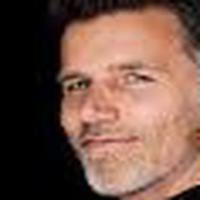

In [22]:
from IPython.display import Image 
Image(filename="f"+str(np.argmax(res))+".jpg")
